In [1]:
import cv2 
from skimage.io import imread
import matplotlib.pyplot as plt
import os
!pip install tensorflow --quiet
from skimage.io import imread
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tifffile as tiff

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


2024-07-25 11:56:32.699776: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 11:56:32.699909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 11:56:32.836075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
! pip install segmentation_models --quiet 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
parent_path_ims = "/kaggle/input/cvcclinicdb/TIF/Original"
ims = os.listdir(parent_path_ims)
image_paths = [os.path.join(parent_path_ims, im) for im in ims]

parent_path_masks = "/kaggle/input/cvcclinicdb/TIF/Ground Truth"
mas = os.listdir(parent_path_masks)
mask_paths = [os.path.join(parent_path_masks, mas) for mas in mas]

In [4]:
import albumentations as A

def augment_data(image, mask):
    # Ensure mask is in the correct format
    image = image.astype(np.float32)
    mask = mask.astype(np.float32)
    
    # Define augmentation pipeline
    aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Transpose(p=0.5),
        A.Resize(192,288,p=1)
    ])
    
    # Apply augmentation
    augmented = aug(image=image, mask=mask)
    return augmented['image'], augmented['mask']


In [5]:
import skimage

def load_image_and_mask(image_path, height=192, width=288, is_training=True, apply_augmentation=True):

    with tiff.TiffFile(image_path) as tiff_im:
        image = tiff_im.asarray()
    
    image = resize(image, (height, width))
        
    if is_training:
        mask_path = image_path.replace("Original", "Ground Truth")
        
        with tiff.TiffFile(mask_path) as tiff_ma:
            mask = tiff_ma.asarray()
            
        mask = resize(mask, (height, width))
                
        if apply_augmentation:
            image, mask = augment_data(image, mask)
            
         # Normalizing the image
        p2, p98 = np.percentile(image, (2, 98))
        image = skimage.exposure.rescale_intensity(image, in_range=(p2, p98), out_range=(0, 1))
#         hist_img =skimage.exposure.equalize_hist(image)

        mask = mask.astype(np.float32)

        
        return image, mask
    else:
        return image


# Training Pipeline

In [6]:
class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, image_paths, is_training=True, batch_size=8, height=192, width=288, apply_augmentation=True):
        self.image_paths = image_paths
        self.is_training = is_training
        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.apply_augmentation = apply_augmentation
        
        
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
        
    def __getitem__(self, index):
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.image_paths))
        
        batch_paths = self.image_paths[start:end]
        X = np.empty((end - start, self.height, self.width, 3), dtype=np.float32)
        
        if self.is_training:
            Y = np.empty((end - start, self.height, self.width), dtype=np.float32)
        
        for i, path in enumerate(batch_paths):
            if self.is_training:
                image, mask = load_image_and_mask(path, height=self.height, width=self.width, 
                                                  is_training=self.is_training, apply_augmentation=self.apply_augmentation)
                X[i] = image
                Y[i] = mask
            else: 
                image = load_image_and_mask(path, height=self.height, width=self.width, 
                                            is_training=self.is_training)
                X[i] = image
                
        if self.is_training:
            return (X, Y)
        return X


In [7]:
import random
# Define paths
image_dir = '/kaggle/input/cvcclinicdb/TIF/Original'
im_names = os.listdir(image_dir)

# Shuffle the list of image names
random.shuffle(im_names)

# Create full paths for all images
image_list = [os.path.join(image_dir, name) for name in im_names]
total_length = len(image_list)



train_list, test_list = train_test_split(image_list, test_size=0.05,random_state = 42)
train_list, val_list = train_test_split(train_list, test_size=0.15789471,random_state = 42)

# Print the sizes of each set to verify
print(f"Total images: {total_length}")
print(f"Training set size: {len(train_list)}")
print(f"Validation set size: {len(val_list)}")
print(f"Test set size: {len(test_list)}")

Total images: 612
Training set size: 489
Validation set size: 92
Test set size: 31


In [8]:
def repeat_list(lst,factor):
    new_lst=[]
    for i in range(int(len(lst)*factor)):
        lst.append(random.choice(lst))
    return lst

#Repeating 80% of the dataset since we are applying augmentation
train_list = repeat_list(train_list,0.8)
len(train_list),len(set(train_list))

(880, 489)

In [9]:
train_generator = Dataloader(train_list, batch_size=8, apply_augmentation=True)
test_generator = Dataloader(val_list, batch_size=8,apply_augmentation=False)

# Batch Visualization

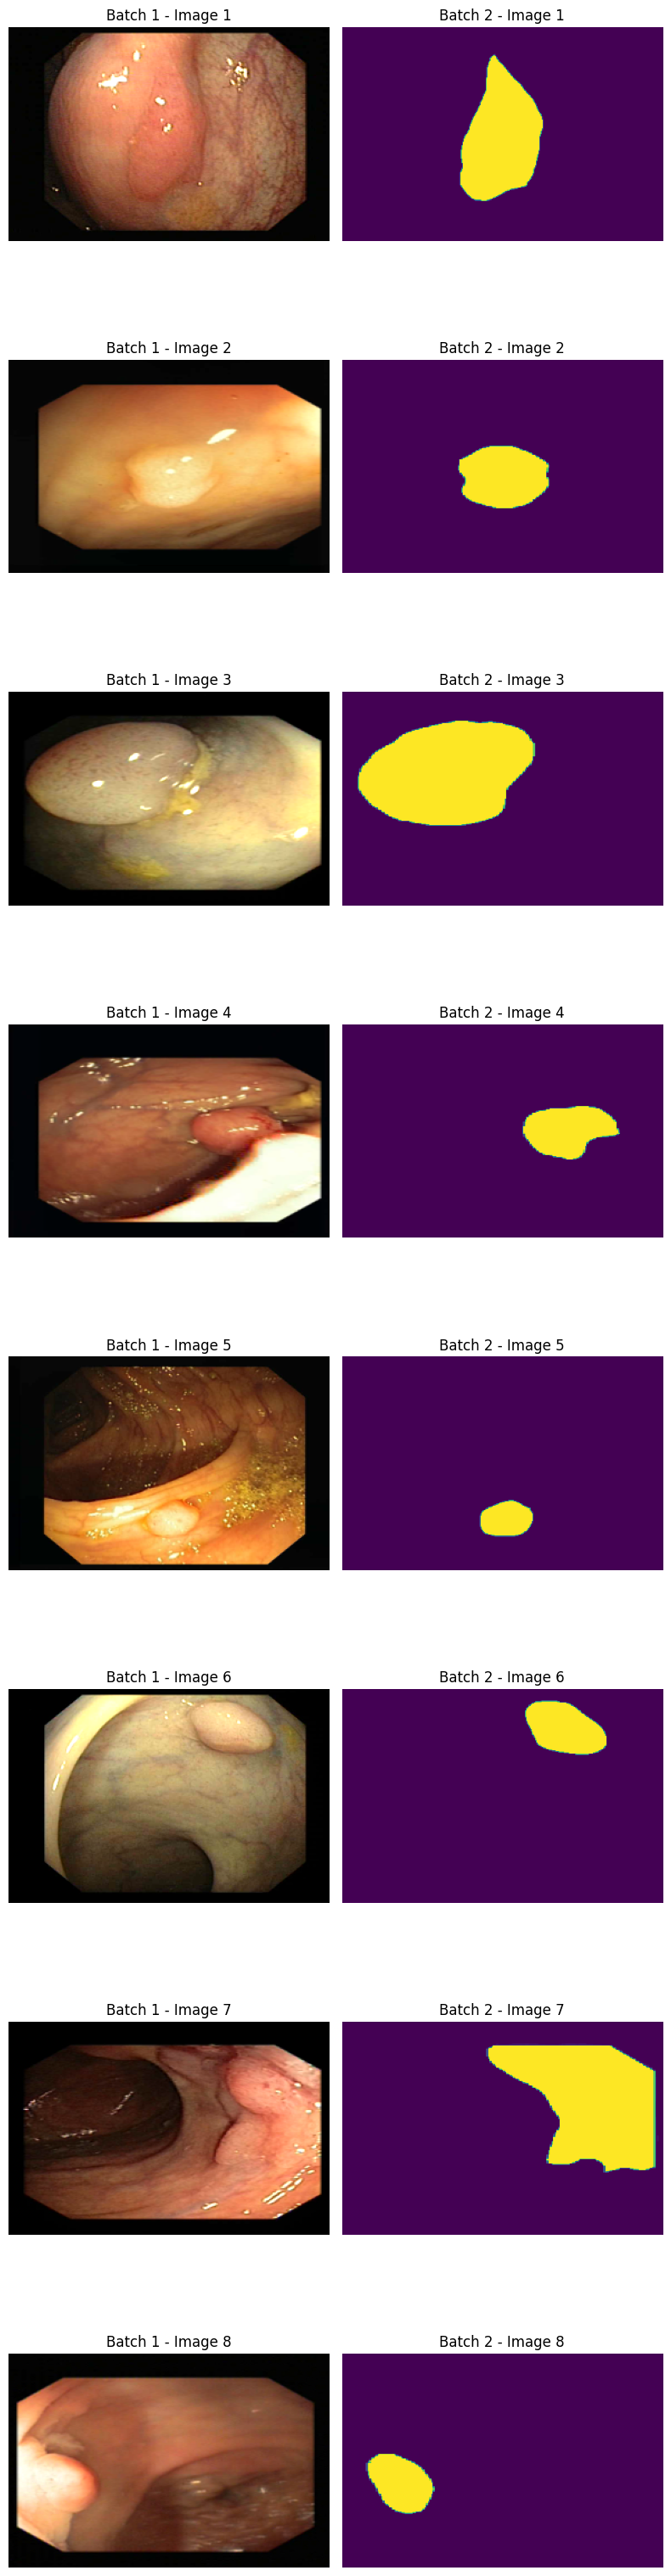

In [10]:
im,ma = train_generator.__getitem__(0)
im1,ma1 = train_generator.__getitem__(1)

def plot_two_batches(batch1, batch2, num_images):
    fig, axs = plt.subplots(num_images, 2, figsize=(8, num_images*4))
    
    for i in range(num_images):
        # Plot image from batch1
        axs[i, 0].imshow(batch1[i])
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Batch 1 - Image {i+1}')
        
        # Plot image from batch2
        axs[i, 1].imshow(batch2[i])
        axs[i, 1].axis('off')
        axs[i, 1].set_title(f'Batch 2 - Image {i+1}')
    
    plt.tight_layout()
    plt.show()

# Example usage
batch1 = im # First batch of images
batch2 = ma # Second batch of images
num_images = 8 # Number of images to display from each batch

plot_two_batches(batch1, batch2, num_images)

# Model Training

In [11]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

sm.set_framework('tf.keras')
keras.backend.set_image_data_format('channels_last')
from segmentation_models.metrics import FScore,IOUScore
from segmentation_models.losses import DiceLoss

# Defining the Metrics and the losses
IOU = IOUScore()
dice = FScore()
dice_loss = DiceLoss()

Segmentation Models: using `tf.keras` framework.


In [12]:
# Setting up a model with FPN architecture and seresnext50 as a backbone
backbone = 'seresnext50'
model = sm.FPN(backbone,encoder_weights="imagenet",input_shape=(288,384,3),classes=1,encoder_freeze=False,activation = 'sigmoid')

# I have let the encoder be trainable but set the learning rate to be low so only persistent features are learnt
model.compile(
    keras.optimizers.Adam(learning_rate = 0.0007),
    loss= dice_loss,
    metrics=[dice,IOU],
)


early_stopping = EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)


# Reduce learning rate on plateau
lr_plateau = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=3,
    verbose=1,
    min_delta=0.00001,
)


104679448/104679448 [==============================] - 0s 0us/step


In [13]:
history = model.fit(
    train_generator,
    epochs=40,
    validation_data = test_generator,
    callbacks = [lr_plateau,early_stopping],
    verbose = 1
) 

Epoch 1/40


I0000 00:00:1721908747.885611      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 [==============================] - 225s 498ms/step - loss: 0.2825 - f1-score: 0.7175 - iou_score: 0.5782 - val_loss: 0.4372 - val_f1-score: 0.5653 - val_iou_score: 0.3993 - lr: 7.0000e-04
Epoch 2/40
110/110 [==============================] - 38s 346ms/step - loss: 0.1714 - f1-score: 0.8286 - iou_score: 0.7125 - val_loss: 0.3841 - val_f1-score: 0.6166 - val_iou_score: 0.4560 - lr: 7.0000e-04
Epoch 3/40
110/110 [==============================] - 38s 341ms/step - loss: 0.1622 - f1-score: 0.8378 - iou_score: 0.7259 - val_loss: 0.2097 - val_f1-score: 0.7945 - val_iou_score: 0.6641 - lr: 7.0000e-04
Epoch 4/40
110/110 [==============================] - 37s 338ms/step - loss: 0.1464 - f1-score: 0.8536 - iou_score: 0.7504 - val_loss: 0.2342 - val_f1-score: 0.7687 - val_iou_score: 0.6265 - lr: 7.0000e-04
Epoch 5/40
110/110 [==============================] - 37s 336ms/step - loss: 0.1307 - f1-score: 0.8693 - iou_score: 0.7724 - val_loss: 0.1210 - val_f1-score: 0.8776 - val_iou_score: 0.78

In [14]:
model.save('FPN_seresnext50_CVC_clinicdb_augmentation(1.8*aug).h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


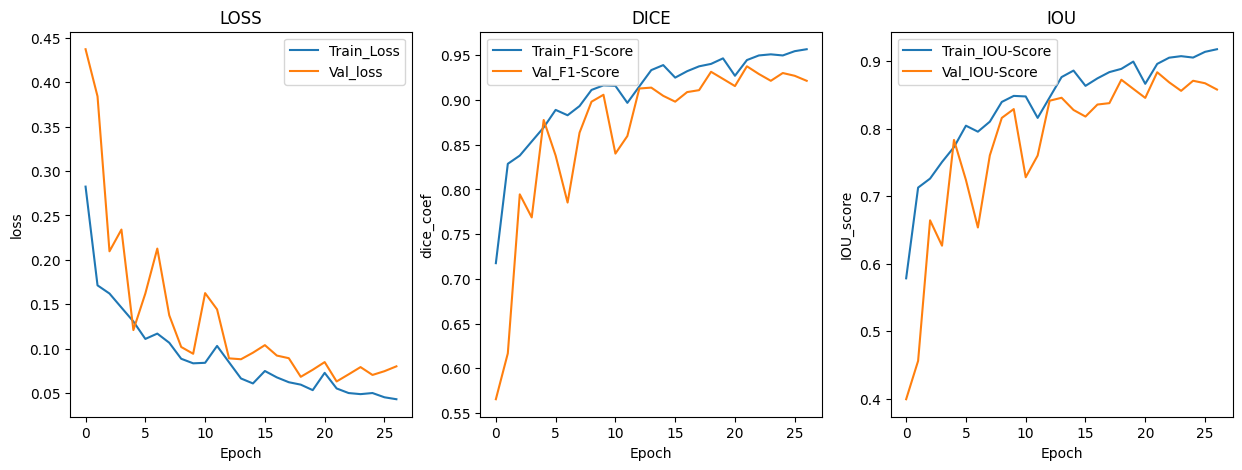

In [15]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history_fpn_sresnext50_cvc(1.8*aug).csv')

# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='Train_Loss')
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

plt.subplot(1,3,2)
plt.plot(range(history.epoch[-1]+1),history.history['f1-score'],label='Train_F1-Score')
plt.plot(range(history.epoch[-1]+1),history.history['val_f1-score'],label='Val_F1-Score')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

plt.subplot(1,3,3)
plt.plot(range(history.epoch[-1]+1),history.history['iou_score'],label='Train_IOU-Score')
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_score'],label='Val_IOU-Score')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('IOU_score');plt.legend(); 


plt.show()


# Model Evaluation

In [16]:
pred_batches = Dataloader(test_list, batch_size=1,is_training=True,apply_augmentation=False)
preds = model.predict(pred_batches)

31/31 [==============================] - 9s 50ms/step


In [17]:
sum_of_dice = 0
sum_of_iou = 0
for i in range(len(test_list)):
    image,mask = pred_batches.__getitem__(i)
    mask = np.expand_dims(mask,axis=-1)
    pred_mask = np.where(preds[i] >= 0.5, 1.0, 0.0).astype(np.float32)
    sum_of_dice += (dice(mask,pred_mask)).numpy()
    sum_of_iou += (IOU(mask,pred_mask)).numpy()
    
print(f"Average Dice Score:{sum_of_dice/len(test_list)}")
print(f"Average IoU Score:{sum_of_iou/len(test_list)}")


Average Dice Score:0.8916463715364414
Average IoU Score:0.8323119011567043


In [18]:
preds[0][:,:,0].shape

(192, 288)

Dice Coefficient: 0.9610242247581482


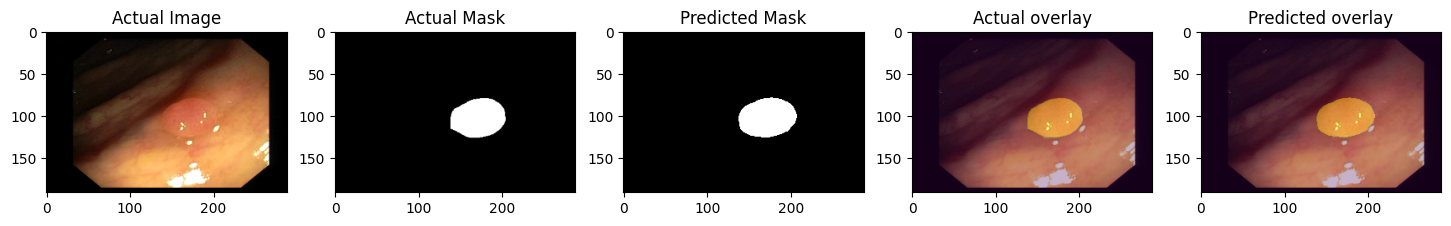

Dice Coefficient: 0.8511161804199219


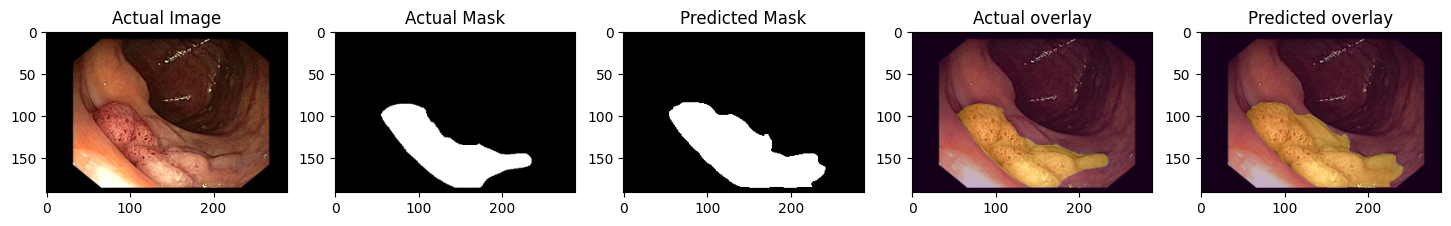

Dice Coefficient: 0.9461957216262817


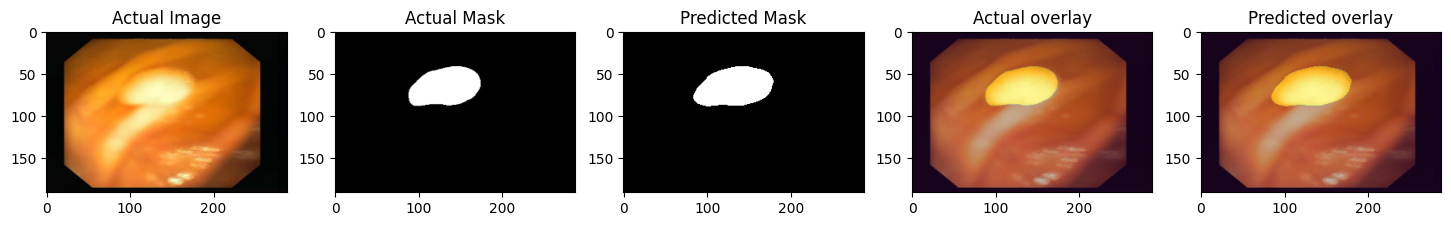

Dice Coefficient: 0.9490693211555481


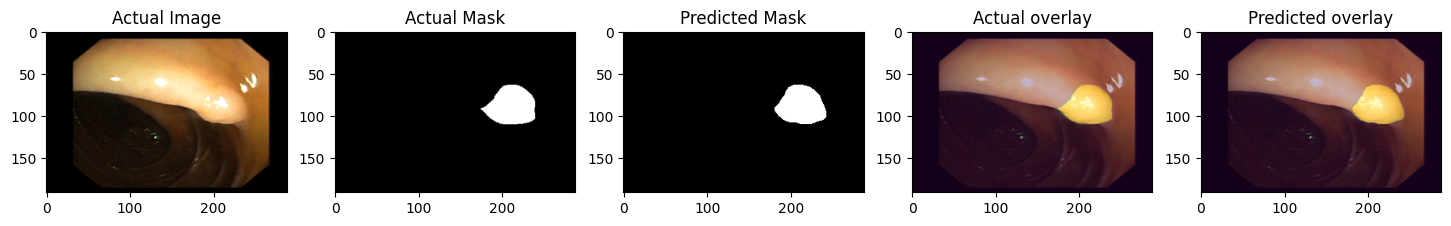

Dice Coefficient: 0.9715859293937683


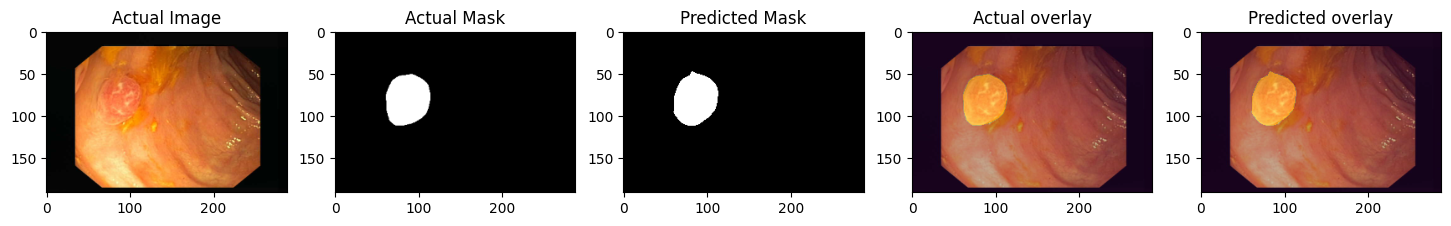

Dice Coefficient: 0.9771817922592163


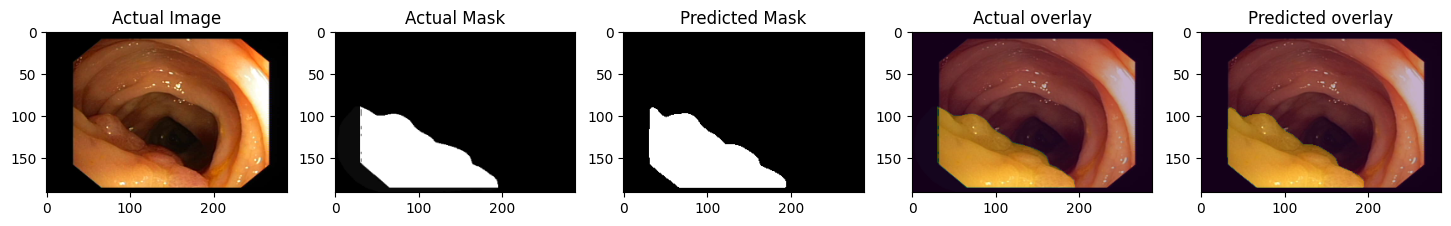

Dice Coefficient: 0.8533061742782593


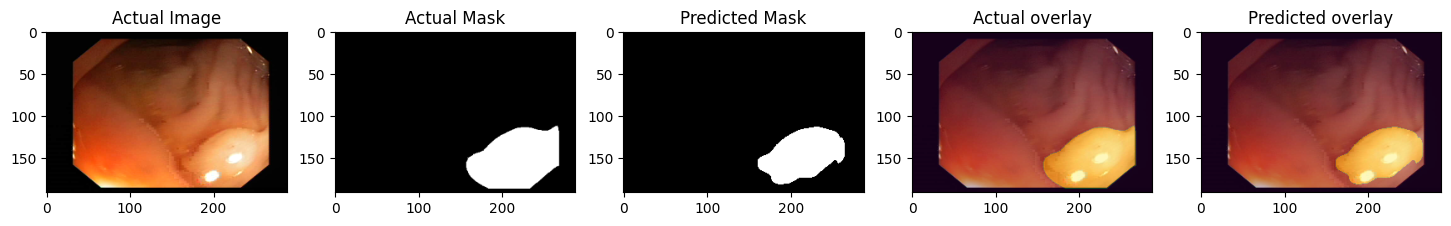

Dice Coefficient: 0.8656401038169861


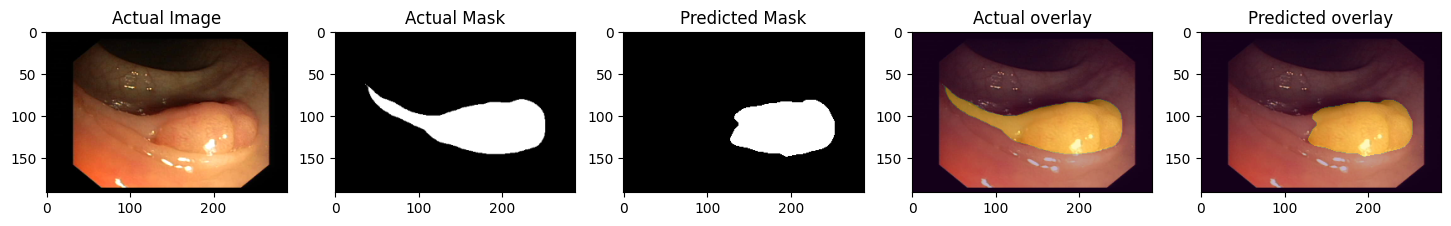

Dice Coefficient: 0.9525414109230042


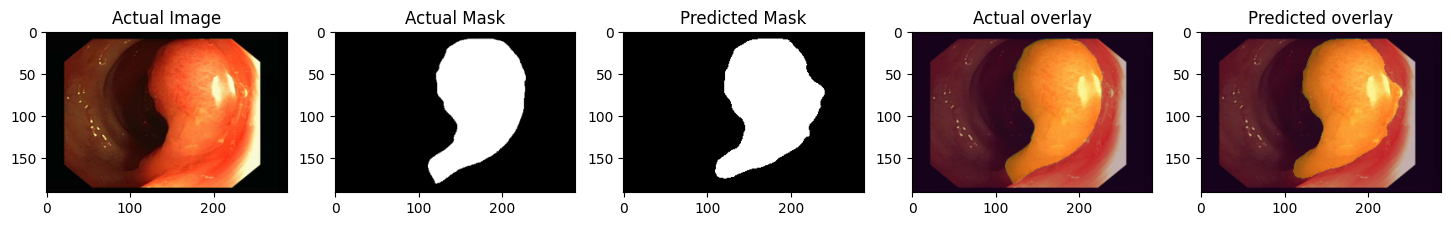

Dice Coefficient: 0.9188011288642883


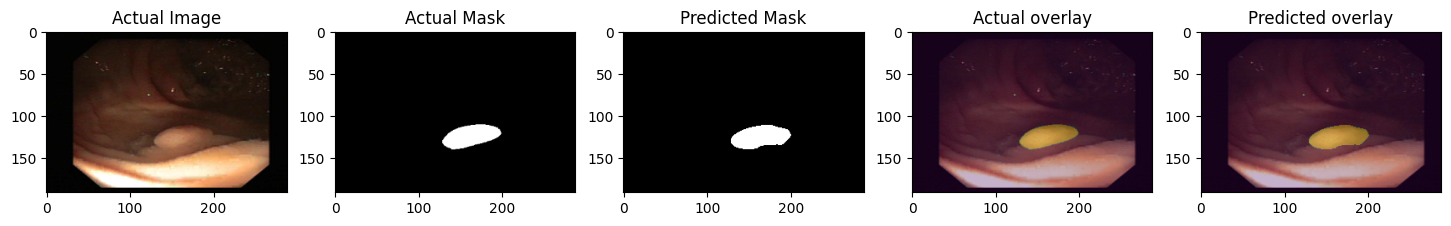

Dice Coefficient: 0.7811650037765503


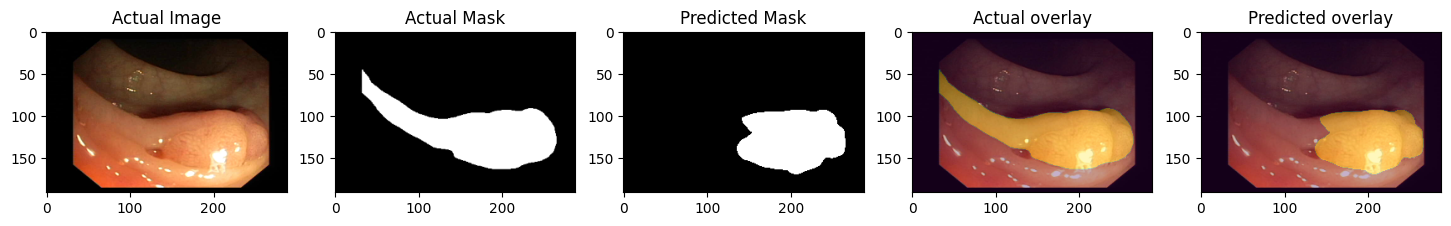

Dice Coefficient: 0.9514918923377991


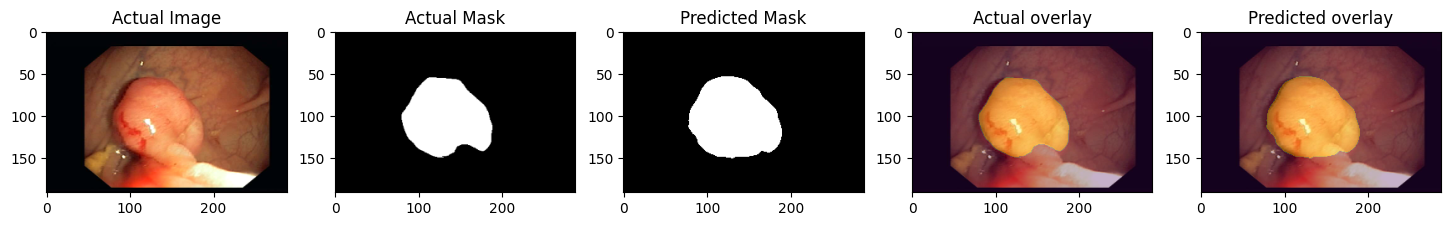

Dice Coefficient: 0.7058048248291016


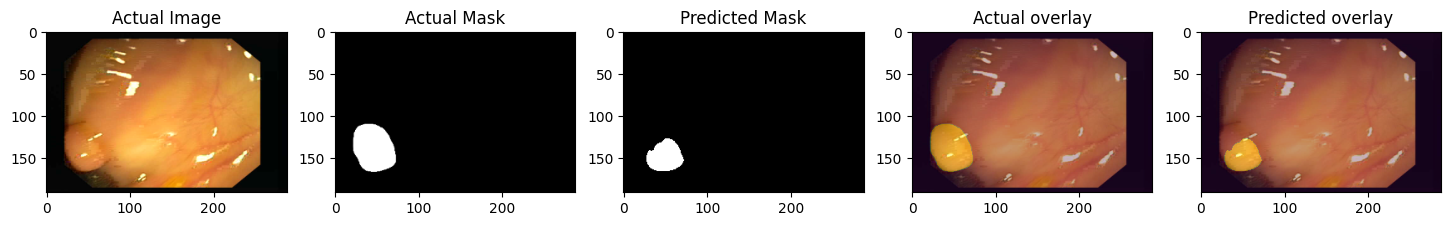

Dice Coefficient: 0.9756133556365967


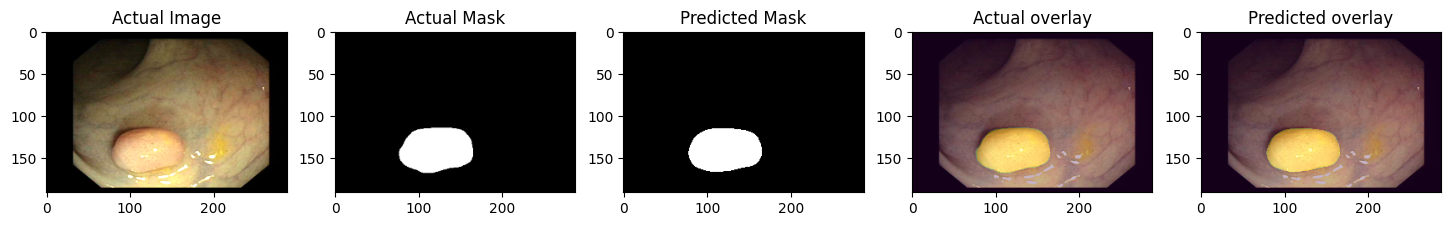

Dice Coefficient: 0.9263944029808044


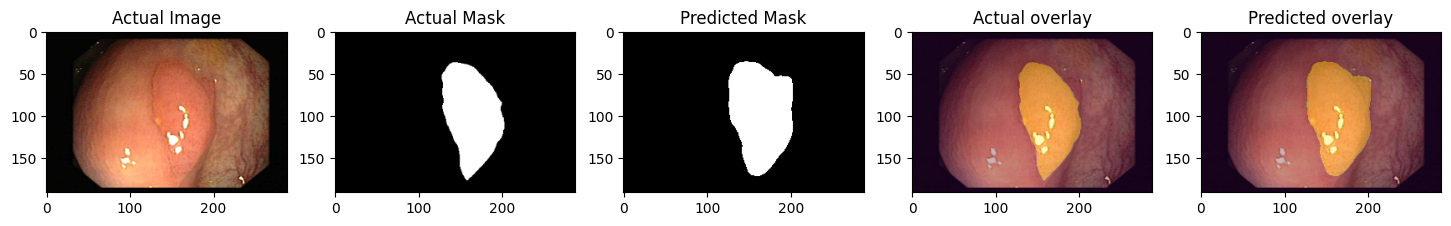

Dice Coefficient: 0.9006140828132629


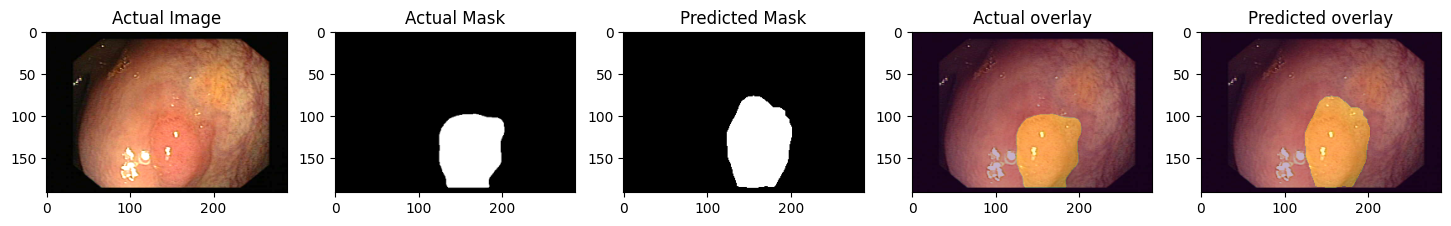

Dice Coefficient: 0.9029521346092224


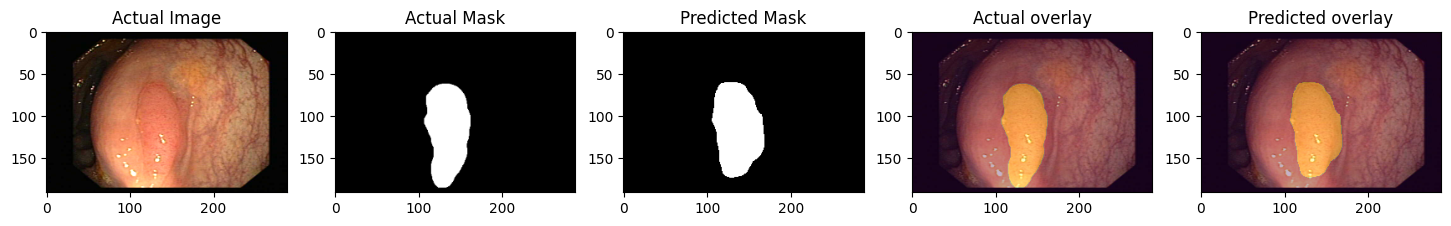

Dice Coefficient: 0.9238871932029724


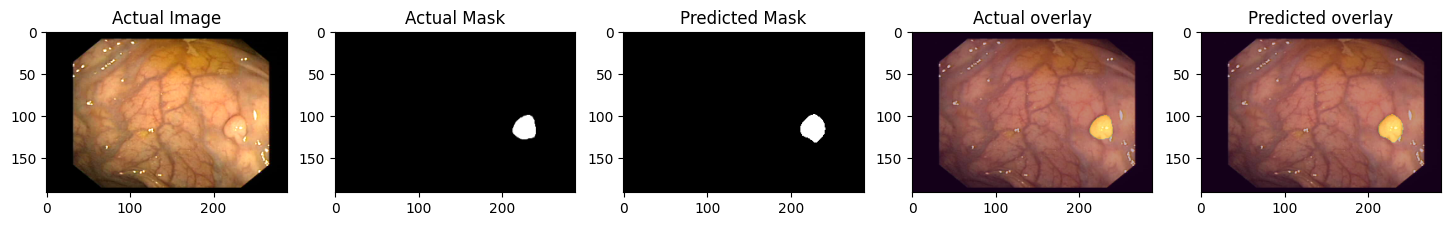

Dice Coefficient: 0.9637889266014099


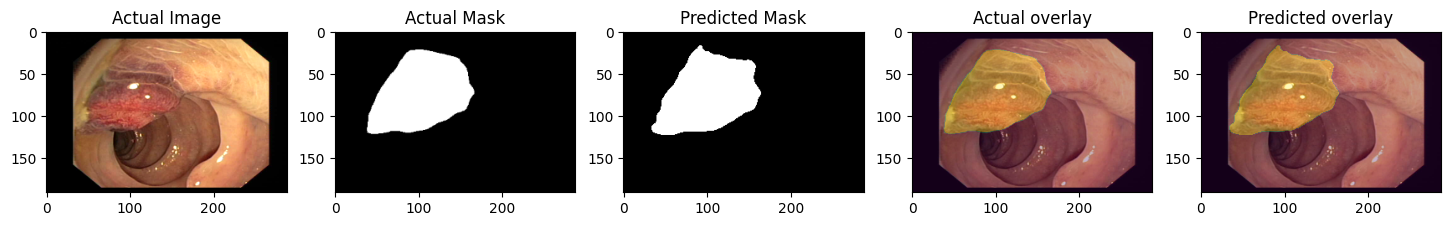

Dice Coefficient: 0.9676550626754761


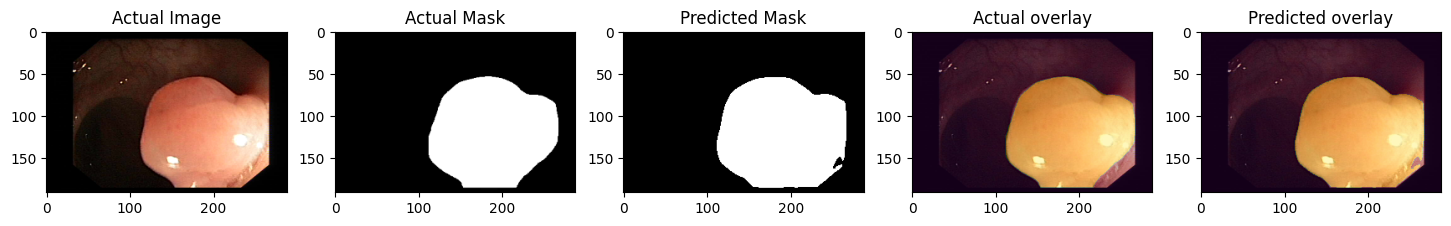

Dice Coefficient: 0.9600701928138733


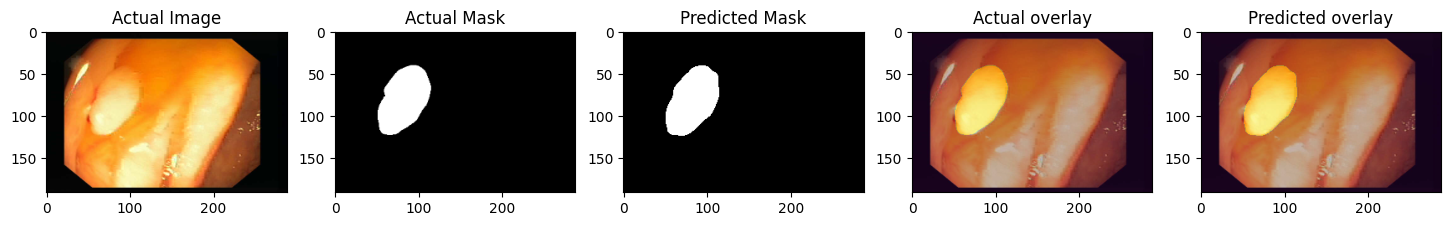

Dice Coefficient: 0.9377943873405457


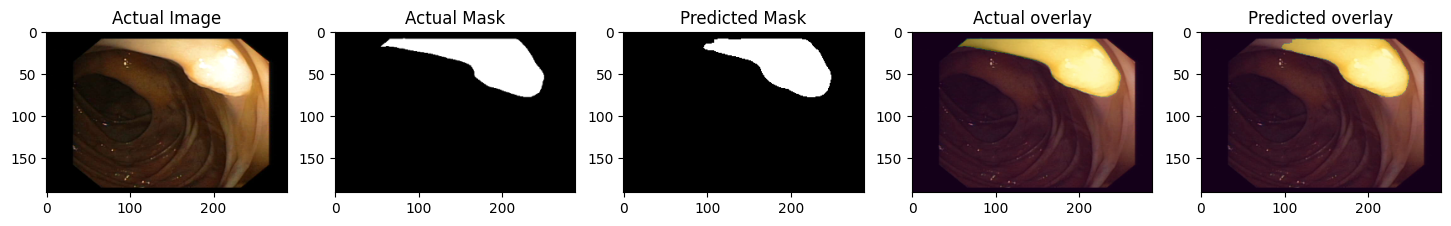

Dice Coefficient: 5.3487838158616796e-08


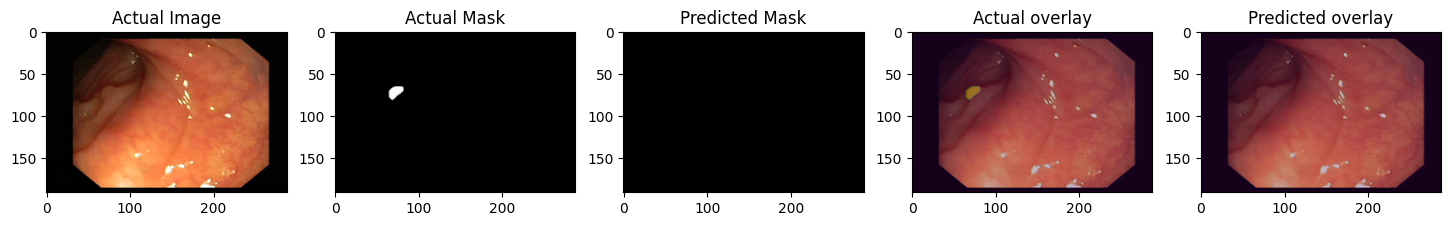

Dice Coefficient: 0.9662994742393494


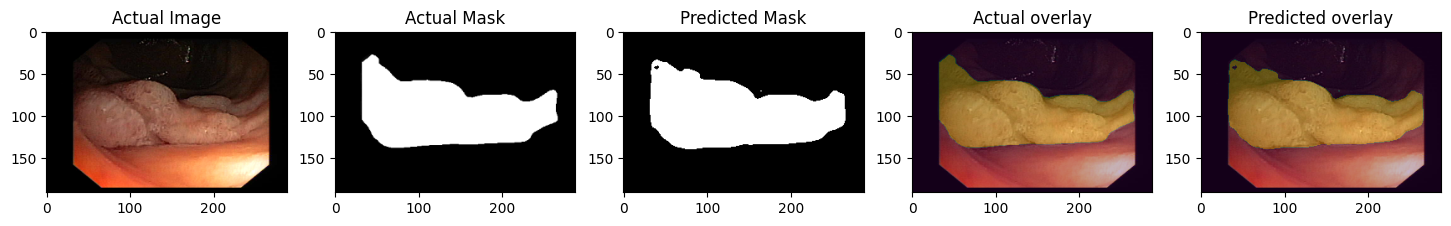

Dice Coefficient: 0.8540678024291992


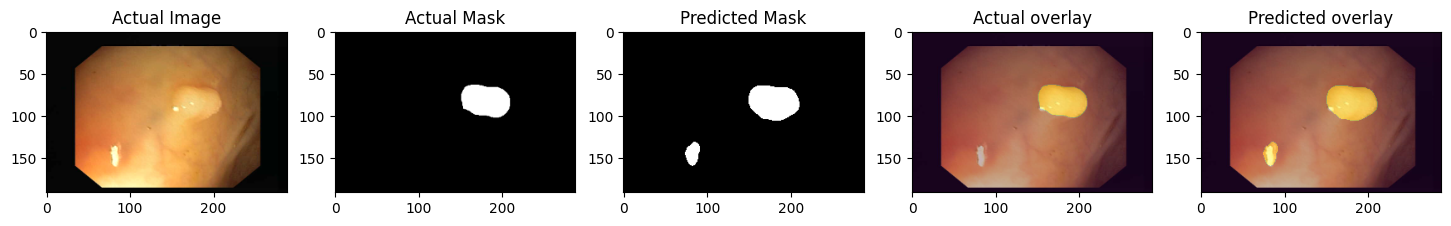

Dice Coefficient: 0.9746307134628296


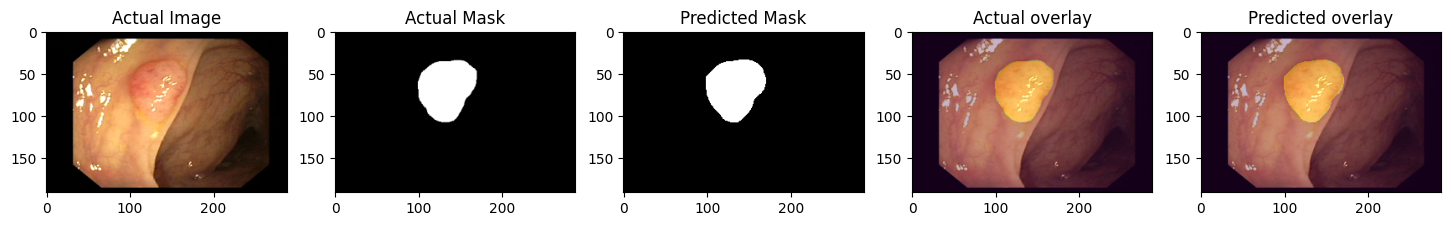

Dice Coefficient: 0.9630873203277588


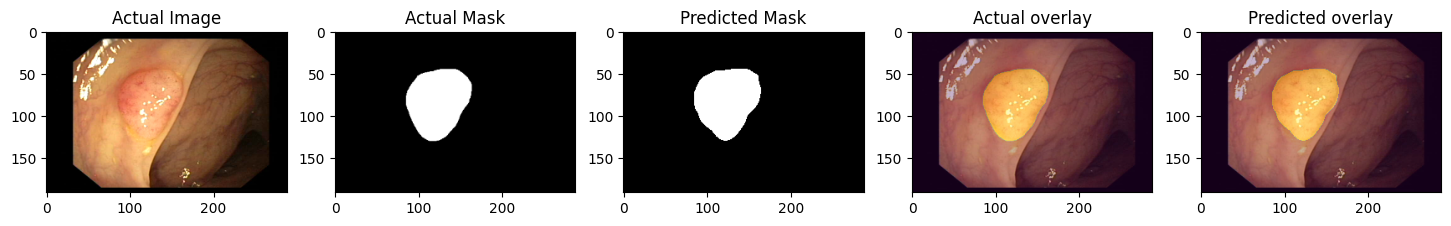

Dice Coefficient: 0.8527103662490845


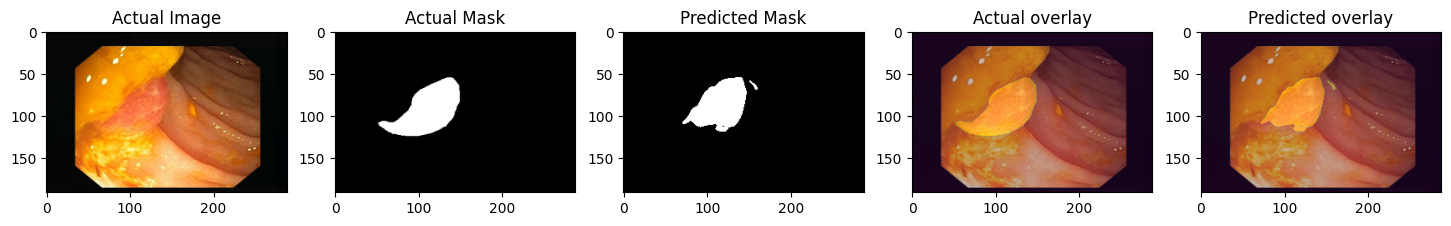

Dice Coefficient: 0.9751220941543579


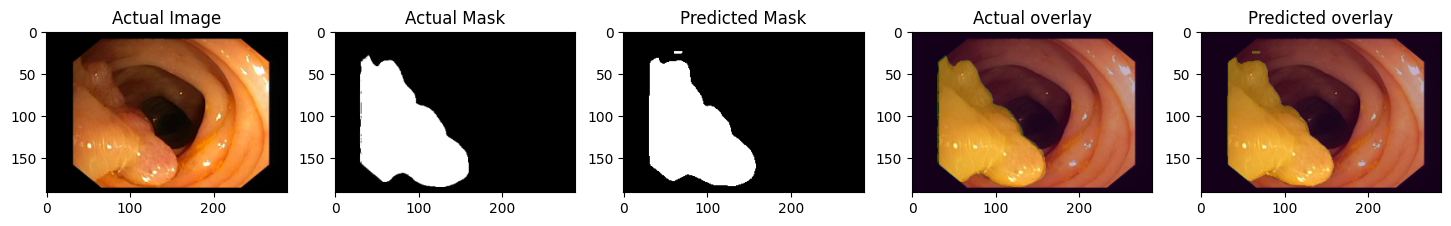

Dice Coefficient: 0.9434808492660522


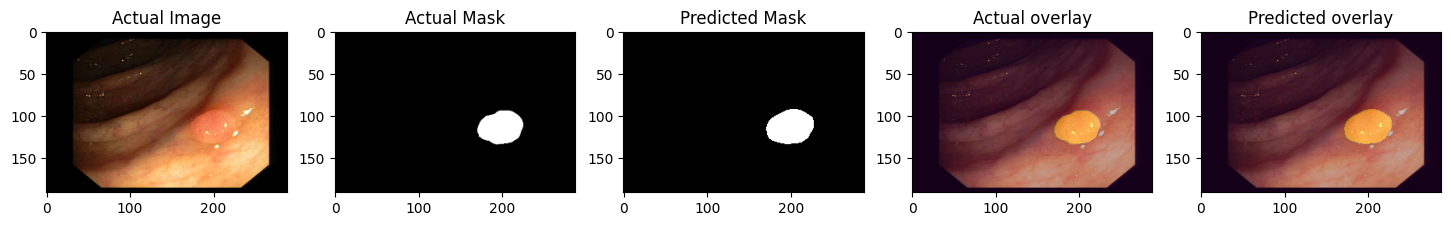

Dice Coefficient: 0.967945396900177


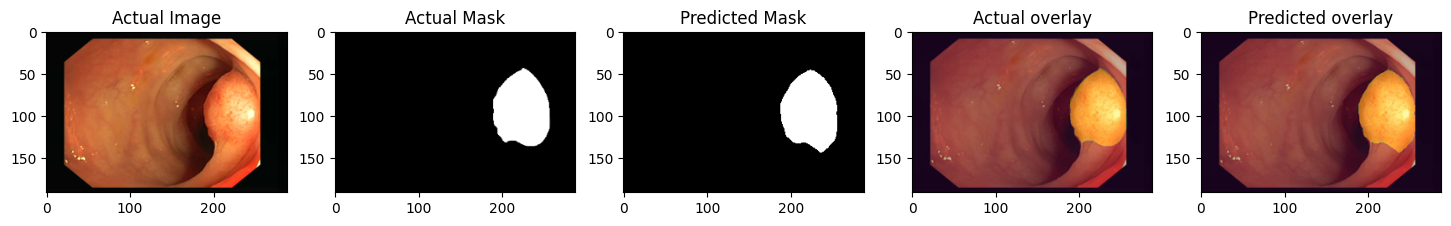

In [19]:
import matplotlib.colors as col

num_rows = len(test_list)  # Number of rows to plot

for i in range(num_rows):
    image_path = test_list[i]  # Assuming ids_val is a list of IDs for the validation set
    actual_image,actual_mask = load_image_and_mask(image_path,is_training=True,apply_augmentation=False)
    
    pred = resize(preds[i],actual_image.shape)

    pred = np.where(preds[i] >= 0.5, 1.0, 0.0).astype(np.float32)
#     pred = pred[:,:,0]

    # Plotting
    plt.figure(figsize=(18, 5))

    # Plot actual image
    plt.subplot(1, 5, 1)
    plt.imshow(actual_image)
    plt.title('Actual Image')

    # Plot actual mask
    plt.subplot(1, 5, 2)
    plt.imshow(actual_mask, cmap='gray')
    plt.title('Actual Mask',)

    # Plot predicted mask
    plt.subplot(1, 5, 3)
    plt.imshow(pred, cmap='gray') 
    plt.title('Predicted Mask')
    
    plt.subplot(1,5,4)
    plt.imshow(actual_mask)
    plt.imshow(actual_image,alpha = 0.7)
    plt.title('Actual overlay')
    
    plt.subplot(1,5,5)
    plt.imshow(pred)
    plt.imshow(actual_image,alpha = 0.7)
    plt.title('Predicted overlay')
    
    print(f'Dice Coefficient: {dice(np.expand_dims(actual_mask,axis=-1),pred).numpy()}')
    
    plt.show()
